In [15]:
import powerplantmatching as pm

In [16]:
import linopy
import numpy as np

In [32]:
import pandas as pd

In [17]:
import pycountry

In [18]:
import geopandas as gpd

In [19]:
power_plants = pm.powerplants()

In [20]:
res = ['Wind', 'Solar', "Hydro"]

In [21]:
power_plants = power_plants.query("(Fueltype not in @res)")

In [22]:
power_plants = power_plants[~(power_plants.DateOut < 2005)]

In [23]:
bidding_zones = gpd.read_file("resources/bidding_zones.geojson")

ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERRO

<AxesSubplot:>

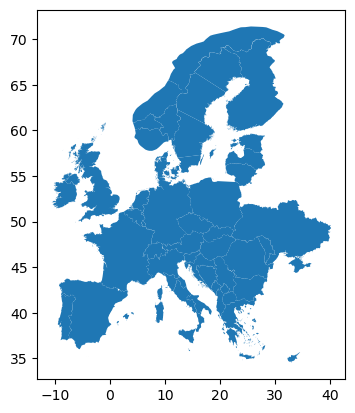

In [24]:
bidding_zones.plot()

In [25]:
power_plant_locations = gpd.GeoDataFrame(index=power_plants.index, geometry=gpd.points_from_xy(power_plants.lon, power_plants.lat), crs="EPSG:4326")
power_plant_locations = power_plant_locations.to_crs("EPSG:3035")

bidding_zones = bidding_zones.to_crs("EPSG:3035")

In [26]:
plant_to_zone = gpd.sjoin_nearest(
    power_plant_locations,
    bidding_zones,
    how="left"
)

In [27]:
plant_to_zone = plant_to_zone.groupby(plant_to_zone.index).last()

In [28]:
power_plants["zone"] = power_plants.index.map(plant_to_zone.zone)

In [38]:
de_minimis = 50

In [41]:
small_plants = power_plants[power_plants.Capacity < de_minimis]

In [55]:
aggregated_small_plants = small_plants.groupby(["Fueltype", "zone"]).Capacity.sum().to_frame().copy()

In [62]:
aggregated_small_plants["Efficiency"] = small_plants.groupby(["Fueltype", "zone"]).Efficiency.mean().to_frame().copy()

In [72]:
for i in aggregated_small_plants[aggregated_small_plants.Efficiency.isna()].index:
    aggregated_small_plants.loc[i, "Efficiency"] = power_plants[power_plants.Fueltype == i[0]].Efficiency.mean()

In [90]:
match_carriers = {
    'Nuclear': "nuclear",
    'Hard Coal': "coal",
    'Lignite': "coal",
    'Natural Gas': np.nan,
    'Oil': "oil",
    'Solid Biomass': "biomass",
    'Other': np.nan,
    'Biogas': "biomass",
    'Waste': np.nan,
    'Geothermal': "geothermal"
}

In [ ]:
power_plants.

In [84]:
aggregated_plants.carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'coal', 'nuclear', 'oil', 'hydrogen'],
      dtype=object)

In [86]:
power_plants.Fueltype.unique()

array(['Nuclear', 'Hard Coal', 'Lignite', 'Natural Gas', 'Oil',
       'Solid Biomass', 'Other', 'Biogas', 'Waste', 'Geothermal'],
      dtype=object)

In [76]:
power_plants.drop(small_plants.index)

Matched Data,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,DateIn,DateRetrofit,DateOut,lat,lon,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,EIC,projectID,zone
id,,,,,,,,,,,,,,,,,,,
0,Kernkraftwerk Emsland,Nuclear,Steam Turbine,PP,Germany,1336.000,0.33,1988.0,1988.0,2023.0,52.472897,7.324140,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE944567587799'}, 'ENTSOE':...",DE00
1,Brokdorf,Nuclear,Steam Turbine,PP,Germany,1410.000,0.33,1986.0,1986.0,2021.0,53.850830,9.344720,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE951462745445'}, 'ENTSOE':...",DE00
2,Borssele,Hard Coal,Steam Turbine,PP,Netherlands,485.000,NaN,1973.0,NaN,2034.0,51.433200,3.716000,NaN,0.0,0.0,0.0,{'49W000000000054X'},"{'BEYONDCOAL': {'BEYOND-NL-2'}, 'ENTSOE': {'49...",NL00
3,Gemeinschaftskernkraftwerk Neckarwestheim,Nuclear,Steam Turbine,PP,Germany,1310.000,0.33,1976.0,1989.0,2023.0,49.040019,9.176408,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE985577062814'}, 'ENTSOE':...",DE00
4,Isar,Nuclear,Steam Turbine,PP,Germany,1410.000,0.33,1979.0,1988.0,2023.0,48.605600,12.293150,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE943690268513'}, 'ENTSOE':...",DE00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29790,Thermisches Burghausen,Natural Gas,Steam Turbine,CHP,Germany,233.900,NaN,1979.0,NaN,NaN,48.181045,12.847345,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE947816911833', 'MASTR-SEE...",DE00
29813,Walheim,Hard Coal,NaN,PP,Germany,244.000,NaN,1964.0,NaN,NaN,49.017585,9.157690,NaN,0.0,0.0,0.0,{},"{'MASTR': {'MASTR-SEE964114029633', 'MASTR-SEE...",DE00
29829,Wd Ffw,Natural Gas,NaN,CHP,Germany,110.755,NaN,1994.0,NaN,NaN,50.099000,8.653000,NaN,0.0,0.0,0.0,{},{'MASTR': {'MASTR-SEE994429144455'}},DE00


In [33]:
aggregated_plants = pd.read_hdf("resources/dispatchable_capacities.h5")

In [36]:
aggregated_plants.entry.unique()

array([2028, 2030, 2033, 2035, 2029, 2031, 2032, 2034])

<AxesSubplot:>

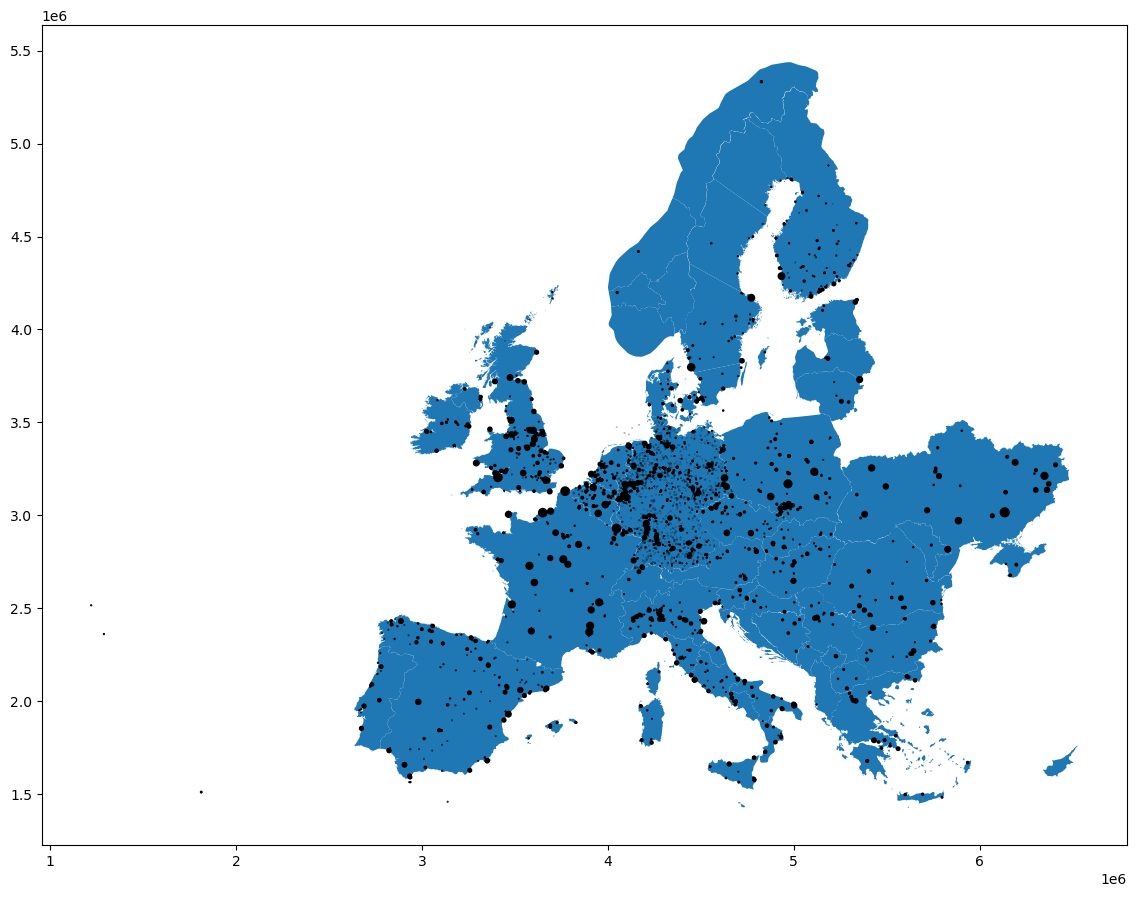

In [29]:
ax = bidding_zones.plot(figsize=(14,14))
power_plant_locations.plot(markersize=power_plants.Capacity.div(150), color="black", ax=ax)